# Introduction to Business Problem #

With nearly 10 million inhabitants and one of the highest metropolitan GDP in the world, an estimated 22 million overseas visitors are expected to flock to the capital and surrounding regions to explore the culture, food and historical shrine.

Bangkok is well-known as the restaurant capital of the world, with over hundread of thousands of places to choose from around it’s 50 districts.

I believe it’s difficult for a traveler, especially restaurant-goers, to make a choice from among many options since there is also too much information on the web because everybody’s got their own take of where to go and it’s all so fragmented that you have to assemble it yourself especially if you’re interested in non-touristy recommendations.

The objective of this report is to help restaurant-goers to make a choice from many option since the amount of information on the internet is abundent, making a decision to pick a restaurant can be time consuming. it will also aid tourist to pick a place with non tourist recommendations.

# Data #

Bangkok data that contains list districts along with their latitude and longitude.

Datasource : https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok

Geopy - For getting the co-ordinated of different locations.
We will Bangkok districts Table from Wikipedia and get the coordinates of these 50 districts using geocoder class of Geopy client.

Data source: Foursquare APIs

Description : By using this API we will get all the venues in each neighborhood. We can filter these venues to get only restaurants.

# Methodology #

## Data Preparation

In [2]:
import numpy as np
import pandas as pd

from geopy.geocoders import Nominatim

!pip install geocoder
import geocoder

import requests
from bs4 import BeautifulSoup

!pip install folium
import folium

from sklearn.cluster import KMeans

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

     |████████████████████████████████| 98 kB 3.6 MB/s eta 0:00:011
     |████████████████████████████████| 93 kB 1.8 MB/s eta 0:00:011


In [3]:
from matplotlib import colors


## Location ##

In [14]:
address = 'Bangkok'

geolocator = Nominatim(user_agent="bkk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangkok are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangkok are 13.7542529, 100.493087.


### Transform data from Wiki to dataframe ###



In [15]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok')[0]
df.head()

,District(Khet),MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444
3,Bang Khen,5,10220,บางเขน,189539,2,13.873889,100.596389
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.693333,100.502500


In [6]:
df.shape

(50, 8)

In [7]:
df.drop("MapNr", axis=1, inplace=True)
df.drop("Post-code", axis=1, inplace=True)
df.drop("Thai", axis=1, inplace=True)
df.drop("Popu-lation", axis=1, inplace=True)
df.drop("No. ofSubdis-trictsKhwaeng", axis=1, inplace=True)

In [19]:
df = df.rename(columns={"District(Khet)": "Name"})

In [20]:
df.head()

,Name,MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444
3,Bang Khen,5,10220,บางเขน,189539,2,13.873889,100.596389
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.693333,100.502500


### Plotting the District on map ###

In [27]:
#Creating a map
bkk_map = folium.Map(location=[latitude, longitude],zoom_start=11)

#adding markers to the map for localities
#marker for Bangkok
folium.Marker([latitude, longitude], popup='<i>Bangkok</i>', color='red', tooltip="Click to see").add_to(bkk_map)

In [26]:
# create map of bkk using latitude and longitude values
map_bkk = folium.Map(location=[latitude, longitude], zoom_start=11)

 # add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bkk) 
    
map_bkk

### Expore district using Foursquare ###

In [28]:
CLIENT_ID = 'LKJGCMNOVQ5F20BUZCTVRXULA4QPEKPME01AW4XTSEFCF5SQ'
CLIENT_SECRET = 'WS1PQFU2AZOK4LTRX4QO2PDW1YYI24YSRLPJUD4Y4NVFCDUI'
VERSION = '20180605'

In [29]:
radius = 2000
LIMIT = 100

venues = []

for lat, lng, district in zip(df["Latitude"], df["Longitude"], df["Name"]):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
    results = requests.get(url).json()['response']['groups'][0]['items']

    for venue in results:
        venues.append((district, lat, lng, venue['venue']['name'], venue['venue']['location']['lat'], venue['venue']['location']['lng'], venue['venue']['categories'][0]['name'], venue['venue']['id']))

In [30]:
venues[0]

('Bang Bon',
 13.6592,
 100.3991,
 'ขาหมูบางหว้า',
 13.657136,
 100.39523,
 'Thai Restaurant',
 '4e880a81f790e992e01d7284')

In [31]:
#Convert the venue list into dataframe
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Name', 'Latitude', 'Longitude', 'Venue name', 'Venue Lat', 'Venue Lng', 'Venue Category', 'Venue ID']
venues_df.head()

,Name,Latitude,Longitude,Venue name,Venue Lat,Venue Lng,Venue Category,Venue ID
0,Bang Bon,13.6592,100.3991,ขาหมูบางหว้า,13.657136,100.395230,Thai Restaurant,4e880a81f790e992e01d7284
1,Bang Bon,13.6592,100.3991,ร้านต้นไม้ ริมถนนกาญจนาภิเษก,13.654098,100.405054,Garden Center,4bf8e392508c0f4796f13e31
2,Bang Bon,13.6592,100.3991,TPD Bowling,13.663977,100.408965,Bowling Alley,52a0891811d20bdfe3d3ed2d
3,Bang Bon,13.6592,100.3991,เจ๊ไน้ ก๋วยเตี๋ยวเป็ดตุ๋น,13.654137,100.405323,Noodle House,4d69adfa342b8cfa9bbccc2c
4,Bang Bon,13.6592,100.3991,Irashaimase Japanese Restaurant,13.658358,100.401403,Japanese Restaurant,5218ae3411d247f3bb76befc


In [32]:
venues_df.shape

(4387, 8)

In [33]:
#Getting the list of all the categories of all the restaurant present in venues_df dataframe
res_df = pd.DataFrame({'Venue Category': venues_df['Venue Category'], 'Count': venues_df['Venue Category']})
res_df = res_df.groupby(['Venue Category']).count()
res_df = res_df.sort_values(['Count'], ascending=False)
print(res_df.head())
print("We can see that most restaurants belongs to Indian Restaurant category i.e. {}".format(res_df['Count'][0]))

                   Count
Venue Category          
Noodle House         376
Thai Restaurant      357
Coffee Shop          332
Convenience Store    259
Café                 166
We can see that most restaurants belongs to Indian Restaurant category i.e. 376


In [34]:
res_df.shape

(266, 1)

In [35]:
demo1_df = pd.DataFrame({'Venue Category':res_df.index[:50]})
category_strength=[]
for i in range(50):
    category_strength.append(res_df['Count'][i])
demo2_df = pd.DataFrame(category_strength, columns=['Count'])
demo_df = pd.DataFrame({'Venue Category': demo1_df['Venue Category'], 'Count': demo2_df['Count']})
demo_df.head()

,Venue Category,Count
0,Noodle House,376
1,Thai Restaurant,357
2,Coffee Shop,332
3,Convenience Store,259
4,Café,166


In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

In [39]:
bkk_venues = getNearbyVenues(names=df['Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Bang Bon
Bang Kapi
Bang Khae
Bang Khen
Bang Kho Laem
Bang Khun Thian
Bang Na
Bang Phlat
Bang Rak
Bang Sue
Bangkok Noi
Bangkok Yai
Bueng Kum
Chatuchak
Chom Thong
Din Daeng
Don Mueang
Dusit
Huai Khwang
Khan Na Yao
Khlong Sam Wa
Khlong San
Khlong Toei
Lak Si
Lat Krabang
Lat Phrao
Min Buri
Nong Chok
Nong Khaem
Pathum Wan
Phasi Charoen
Phaya Thai
Phra Khanong
Phra Nakhon
Pom Prap Sattru Phai
Prawet
Rat Burana
Ratchathewi
Sai Mai
Samphanthawong
Saphan Sung
Sathon
Suan Luang
Taling Chan
Thawi Watthana
Thon Buri
Thung Khru
Wang Thonglang
Watthana
Yan Nawa


In [40]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

bkk_Venues_only_restaurant = bkk_venues[bkk_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
bkk_Venues_only_restaurant.index = np.arange(1, len(bkk_Venues_only_restaurant )+1)

In [41]:
print (bkk_Venues_only_restaurant['Venue Category'].value_counts())

Thai Restaurant                  65
Asian Restaurant                 45
Chinese Restaurant               29
Japanese Restaurant              29
Som Tum Restaurant               25
Fast Food Restaurant             23
Hotpot Restaurant                20
Seafood Restaurant               17
Restaurant                       14
Shabu-Shabu Restaurant           10
Sushi Restaurant                  9
Italian Restaurant                8
Dim Sum Restaurant                7
Ramen Restaurant                  6
Vietnamese Restaurant             5
Halal Restaurant                  4
Korean Restaurant                 4
Vegetarian / Vegan Restaurant     2
American Restaurant               2
Comfort Food Restaurant           2
Donburi Restaurant                2
Japanese Curry Restaurant         2
Dumpling Restaurant               1
German Restaurant                 1
Mexican Restaurant                1
Udon Restaurant                   1
New American Restaurant           1
Cantonese Restaurant        

In [42]:
print('There are {} uniques categories.'.format(len(bkk_Venues_only_restaurant['Venue Category'].unique())))

There are 31 uniques categories.


In [43]:
# create a dataframe of top 10 categories
bkk_5_Dist_Venues_Top10 = bkk_Venues_only_restaurant['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
bkk_5_Dist_Venues_Top10=bkk_5_Dist_Venues_Top10.reset_index()
#bkk_5_Dist_Venues_Top10

bkk_5_Dist_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
bkk_5_Dist_Venues_Top10

,Venue_Category,Frequency
0,Thai Restaurant,65
1,Asian Restaurant,45
2,Chinese Restaurant,29
3,Japanese Restaurant,29
4,Som Tum Restaurant,25
5,Fast Food Restaurant,23
6,Hotpot Restaurant,20
7,Seafood Restaurant,17
8,Restaurant,14
9,Shabu-Shabu Restaurant,10


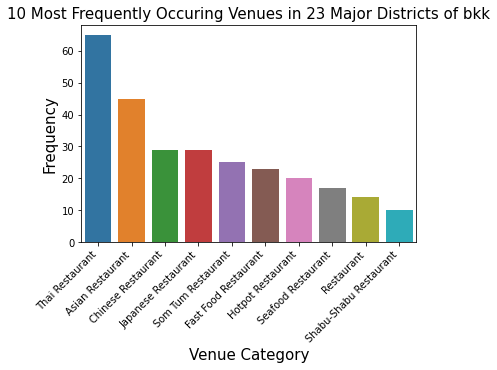

<Figure size 1296x504 with 0 Axes>

In [44]:
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Venue_Category", y="Frequency", data=bkk_5_Dist_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Occuring Venues in 23 Major Districts of bkk', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

### Check the size of the resulting dataframe

In [45]:
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", bkk_Venues_only_restaurant.shape)
bkk_Venues_only_restaurant.head(10)

Shape of the Data-Frame with Venue Category only Restaurant:  (339, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Bang Bon,13.659200,100.399100,ขาหมูบางหว้า,13.657136,100.395230,Thai Restaurant
2,Bang Bon,13.659200,100.399100,Irashaimase Japanese Restaurant,13.658358,100.401403,Japanese Restaurant
3,Bang Bon,13.659200,100.399100,บ้านพลูหลวง เอกชัย,13.658482,100.398440,Asian Restaurant
4,Bang Bon,13.659200,100.399100,บ้านพลูหลวง,13.658532,100.398442,Thai Restaurant
5,Bang Kapi,13.765833,100.647778,Shabushi (ชาบูชิ),13.767332,100.643828,Shabu-Shabu Restaurant
6,Bang Kapi,13.765833,100.647778,Hachiban Ramen (ฮะจิบัง ราเมน),13.767572,100.643591,Ramen Restaurant
7,Bang Kapi,13.765833,100.647778,MK (เอ็มเค),13.767380,100.643581,Hotpot Restaurant
8,Bang Khae,13.696111,100.409444,McDonald's & McCafé (แมคโดนัลด์ & แมคคาเฟ่),13.695474,100.407852,Fast Food Restaurant
9,Bang Khen,13.873889,100.596389,ต้มเลือดหมูตำลึง & ข้าวหมูทอด,13.874413,100.600190,Asian Restaurant
10,Bang Khen,13.873889,100.596389,ไทยอีสาน 2005,13.874824,100.599660,Som Tum Restaurant


In [46]:
bkk_Venues_restaurant = bkk_Venues_only_restaurant.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())

## Analyze Each district ##

In [47]:
bkk_Venues_restaurant

Neighborhood
Bang Bon                 4
Bang Kapi                3
Bang Khae                1
Bang Khen                4
Bang Kho Laem            7
Bang Khun Thian         13
Bang Na                  5
Bang Phlat               2
Bang Rak                 8
Bang Sue                 5
Bangkok Noi              7
Bangkok Yai              6
Bueng Kum                2
Chatuchak                4
Chom Thong               3
Don Mueang               1
Dusit                    3
Huai Khwang              6
Khan Na Yao             17
Khlong Sam Wa            5
Khlong San              10
Khlong Toei              1
Lak Si                   7
Lat Krabang              4
Lat Phrao                5
Min Buri                 1
Nong Chok                2
Nong Khaem               1
Pathum Wan              31
Phasi Charoen           13
Phaya Thai              38
Phra Khanong             5
Phra Nakhon              9
Pom Prap Sattru Phai    11
Prawet                   2
Rat Burana               8
Ratchathewi    

In [77]:
bkk_Venues_restaurant_df  = bkk_Venues_restaurant.to_frame().reset_index()
bkk_Venues_restaurant_df.columns = ['Neighborhood', 'Number of Restaurant']
bkk_Venues_restaurant_df.index = np.arange(1, len(bkk_Venues_restaurant_df)+1)
list_rest_no =bkk_Venues_restaurant_df['Number of Restaurant'].to_list()
list_dist =bkk_Venues_restaurant_df['Neighborhood'].to_list()
#print (list_rest_no)
#print (list_dist)

In [49]:
# one hot encoding
bkk_onehot = pd.get_dummies(bkk_Venues_only_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bkk_onehot['Neighborhood'] = bkk_Venues_only_restaurant['Neighborhood'] 

In [50]:
# move neighborhood column to the first column
fixed_columns = [bkk_onehot.columns[-1]] + bkk_5_Dist_Venues_restaurant_df = bkk_5_Dist_Venues_restaurant.to_frame().reset_index()
bkk_5_Dist_Venues_restaurant_df.columns = ['District', 'Number of Restaurant'](bkk_onehot.columns[:-1])
bkk_onehot = bkk_onehot[fixed_columns]

bkk_onehot.head()

SyntaxError: can't assign to operator (<ipython-input-50-0099c73daa70>, line 2)

In [52]:
# And let's examine the new dataframe size.
bkk_onehot.shape

(339, 32)

In [53]:
bkk_grouped = bkk_onehot.groupby('Neighborhood').mean().reset_index()
bkk_grouped

,Neighborhood,American Restaurant,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Donburi Restaurant,Dumpling Restaurant,Fast Food Restaurant,...,Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Som Tum Restaurant,Sushi Restaurant,Thai Restaurant,Tonkatsu Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Bang Bon,0.000000,0.250000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
1,Bang Kapi,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bang Khae,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Bang Khen,0.000000,0.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000
4,Bang Kho Laem,0.000000,0.000000,0.0,0.285714,0.000000,0.000000,0.000000,0.000000,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.142857
5,Bang Khun Thian,0.000000,0.000000,0.0,0.076923,0.000000,0.000000,0.000000,0.000000,0.076923,...,0.153846,0.000000,0.000000,0.000000,0.000000,0.230769,0.000000,0.000000,0.000000,0.000000
6,Bang Na,0.000000,0.400000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000
7,Bang Phlat,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
8,Bang Rak,0.000000,0.000000,0.0,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.125000,0.125000,0.125000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000
9,Bang Sue,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000


In [188]:
bkk_grouped.shape

(49, 32)

### Top 5 most common venues

In [56]:
num_top_venues = 5

for hood in bkk_grouped['Neighborhood']:
    
    print("--",hood,"--")
    
    temp = bkk_grouped[bkk_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

-- Bang Bon --
                           venue  freq
0                Thai Restaurant  0.50
1            Japanese Restaurant  0.25
2               Asian Restaurant  0.25
3              Korean Restaurant  0.00
4  Vegetarian / Vegan Restaurant  0.00


-- Bang Kapi --
                    venue  freq
0  Shabu-Shabu Restaurant  0.33
1        Ramen Restaurant  0.33
2       Hotpot Restaurant  0.33
3     American Restaurant  0.00
4       Korean Restaurant  0.00


-- Bang Khae --
                           venue  freq
0           Fast Food Restaurant   1.0
1            American Restaurant   0.0
2              Korean Restaurant   0.0
3  Vegetarian / Vegan Restaurant   0.0
4                Udon Restaurant   0.0


-- Bang Khen --
                           venue  freq
0               Asian Restaurant  0.50
1          Vietnamese Restaurant  0.25
2             Som Tum Restaurant  0.25
3              Korean Restaurant  0.00
4  Vegetarian / Vegan Restaurant  0.00


-- Bang Kho Laem --
               

In [57]:
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [58]:

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bkk_grouped['Neighborhood']

for ind in np.arange(bkk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bkk_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bang Bon,Thai Restaurant,Japanese Restaurant,Asian Restaurant,Japanese Curry Restaurant,Cantonese Restaurant
1,Bang Kapi,Shabu-Shabu Restaurant,Ramen Restaurant,Hotpot Restaurant,Vietnamese Restaurant,Italian Restaurant
2,Bang Khae,Fast Food Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Asian Restaurant,Cantonese Restaurant
3,Bang Khen,Asian Restaurant,Vietnamese Restaurant,Som Tum Restaurant,Japanese Curry Restaurant,Cantonese Restaurant
4,Bang Kho Laem,Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Hotpot Restaurant


# Cluster Neighborhoods #

#### Run k-means to cluster the neighborhood into 5 clusters 

In [59]:
# set number of clusters
kclusters = 5

bkk_grouped_clustering = bkk_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bkk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 4, 1, 0, 4, 4, 0, 4, 4, 3], dtype=int32)

In [60]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bkk_merged = df

bkk_merged.rename(columns={'Name':'Neighborhood'}, inplace=True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bkk_merged = bkk_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bkk_merged.head() # check the last columns!

,Neighborhood,MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100,4.0,Thai Restaurant,Japanese Restaurant,Asian Restaurant,Japanese Curry Restaurant,Cantonese Restaurant
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778,4.0,Shabu-Shabu Restaurant,Ramen Restaurant,Hotpot Restaurant,Vietnamese Restaurant,Italian Restaurant
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444,1.0,Fast Food Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Asian Restaurant,Cantonese Restaurant
3,Bang Khen,5,10220,บางเขน,189539,2,13.873889,100.596389,0.0,Asian Restaurant,Vietnamese Restaurant,Som Tum Restaurant,Japanese Curry Restaurant,Cantonese Restaurant
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.693333,100.502500,4.0,Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Hotpot Restaurant


## Examine the Clusters

In [91]:
# create map
map_restaurants10 = folium.Map(location=[latitude,longitude], tiles='cartodbpositron', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters

col = ['red', 'green', 'blue']


# add markers to the map
for lat, lon, poi, cluster in zip(bkk_merged['Latitude'], 
                                  bkk_merged['Longitude'], 
                                  bkk_merged['Neighborhood'], 
                                  bkk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=13,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10

In [61]:
bkk_merged.loc[bkk_merged['Cluster Labels'] == 0, bkk_merged.columns[[0] + list(range(1, bkk_merged.shape[1]))]]

,Neighborhood,MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Bang Khen,5,10220,บางเขน,189539,2,13.873889,100.596389,0.0,Asian Restaurant,Vietnamese Restaurant,Som Tum Restaurant,Japanese Curry Restaurant,Cantonese Restaurant
6,Bang Na,47,10260,บางนา,95912,2,13.680081,100.591800,0.0,Asian Restaurant,Thai Restaurant,Seafood Restaurant,Vietnamese Restaurant,Italian Restaurant
10,Bangkok Noi,20,10700,บางกอกน้อย,117793,5,13.770867,100.467933,0.0,Som Tum Restaurant,Asian Restaurant,Shabu-Shabu Restaurant,Dim Sum Restaurant,Vietnamese Restaurant
11,Bangkok Yai,16,10600,บางกอกใหญ่,72321,2,13.722778,100.476389,0.0,Asian Restaurant,Thai Restaurant,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant
12,Bueng Kum,27,10240,บึงกุ่ม,145830,3,13.785278,100.669167,0.0,Asian Restaurant,New American Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Cantonese Restaurant
17,Dusit,2,10300,ดุสิต,107655,5,13.776944,100.520556,0.0,Asian Restaurant,Som Tum Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Cantonese Restaurant
18,Huai Khwang,17,10310,ห้วยขวาง,78175,3,13.776667,100.579444,0.0,Som Tum Restaurant,Asian Restaurant,Chinese Restaurant,Restaurant,Hotpot Restaurant
24,Lat Krabang,11,10520,ลาดกระบัง,163175,6,13.722317,100.759669,0.0,Thai Restaurant,Asian Restaurant,Som Tum Restaurant,Vietnamese Restaurant,Italian Restaurant
25,Lat Phrao,38,10230,ลาดพร้าว,122182,2,13.803611,100.607500,0.0,Asian Restaurant,Som Tum Restaurant,Hotpot Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant
27,Nong Chok,3,10530,หนองจอก,157138,8,13.855556,100.862500,0.0,Asian Restaurant,Seafood Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Cantonese Restaurant


In [62]:
bkk_merged.loc[bkk_merged['Cluster Labels'] == 1, bkk_merged.columns[[0] + list(range(1, bkk_merged.shape[1]))]]

,Neighborhood,MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444,1.0,Fast Food Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Asian Restaurant,Cantonese Restaurant
32,Phra Khanong,9,10260,พระโขนง,93482,2,13.702222,100.601667,1.0,Fast Food Restaurant,Italian Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Asian Restaurant


In [63]:
bkk_merged.loc[bkk_merged['Cluster Labels'] == 2, bkk_merged.columns[[0] + list(range(1, bkk_merged.shape[1]))]]

,Neighborhood,MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,Don Mueang,36,10210,ดอนเมือง,166261,3,13.913611,100.589722,2.0,Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Asian Restaurant,Cantonese Restaurant
35,Prawet,32,10250,ประเวศ,160671,3,13.716944,100.694444,2.0,Comfort Food Restaurant,Halal Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Asian Restaurant
37,Ratchathewi,37,10400,ราชเทวี,73035,4,13.758889,100.534444,2.0,Restaurant,Chinese Restaurant,Korean Restaurant,Som Tum Restaurant,Vietnamese Restaurant
39,Samphanthawong,13,10100,สัมพันธวงศ์,27452,3,13.731389,100.514167,2.0,Restaurant,Chinese Restaurant,Japanese Restaurant,Dim Sum Restaurant,French Restaurant
43,Taling Chan,19,10170,ตลิ่งชัน,106604,6,13.776944,100.456667,2.0,Seafood Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Asian Restaurant,Cantonese Restaurant
45,Thon Buri,15,10600,ธนบุรี,119708,7,13.725000,100.485833,2.0,Seafood Restaurant,Restaurant,Vietnamese Restaurant,Italian Restaurant,Asian Restaurant
46,Thung Khru,49,10140,ทุ่งครุ,116473,2,13.647200,100.495800,2.0,Japanese Curry Restaurant,Vietnamese Restaurant,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant


In [64]:
bkk_merged.loc[bkk_merged['Cluster Labels'] == 3, bkk_merged.columns[[0] + list(range(1, bkk_merged.shape[1]))]]

,Neighborhood,MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,Bang Sue,29,10800,บางซื่อ,132234,2,13.809722,100.537222,3.0,Thai Restaurant,Seafood Restaurant,Hotpot Restaurant,Vietnamese Restaurant,Italian Restaurant
13,Chatuchak,30,10900,จตุจักร,160906,5,13.828611,100.559722,3.0,Thai Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Asian Restaurant
22,Khlong Toei,33,10110,คลองเตย,109041,3,13.708056,100.583889,3.0,Thai Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Asian Restaurant,Cantonese Restaurant
26,Min Buri,10,10510,มีนบุรี,137251,2,13.813889,100.748056,3.0,Thai Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Asian Restaurant,Cantonese Restaurant
28,Nong Khaem,23,10160,หนองแขม,150218,2,13.704722,100.348889,3.0,Thai Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Asian Restaurant,Cantonese Restaurant
38,Sai Mai,42,10220,สายไหม,188123,3,13.919167,100.645833,3.0,Thai Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Asian Restaurant,Cantonese Restaurant


In [65]:
bkk_merged.loc[bkk_merged['Cluster Labels'] == 4, bkk_merged.columns[[0] + list(range(1, bkk_merged.shape[1]))]]

,Neighborhood,MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100,4.0,Thai Restaurant,Japanese Restaurant,Asian Restaurant,Japanese Curry Restaurant,Cantonese Restaurant
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778,4.0,Shabu-Shabu Restaurant,Ramen Restaurant,Hotpot Restaurant,Vietnamese Restaurant,Italian Restaurant
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.693333,100.502500,4.0,Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Hotpot Restaurant
5,Bang Khun Thian,21,10150,บางขุนเทียน,165491,2,13.660833,100.435833,4.0,Japanese Restaurant,Thai Restaurant,Restaurant,Fast Food Restaurant,Ramen Restaurant
7,Bang Phlat,25,10700,บางพลัด,99273,4,13.793889,100.505000,4.0,Thai Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Asian Restaurant
8,Bang Rak,4,10500,บางรัก,45875,5,13.730833,100.524167,4.0,Chinese Restaurant,Thai Restaurant,Seafood Restaurant,Som Tum Restaurant,Shabu-Shabu Restaurant
14,Chom Thong,35,10150,จอมทอง,158005,4,13.677222,100.484722,4.0,American Restaurant,Thai Restaurant,Fast Food Restaurant,Japanese Curry Restaurant,Asian Restaurant
19,Khan Na Yao,43,10230,คันนายาว,88678,2,13.827100,100.674300,4.0,Japanese Restaurant,Thai Restaurant,Shabu-Shabu Restaurant,Fast Food Restaurant,Tonkatsu Restaurant
20,Khlong Sam Wa,46,10510,คลองสามวา,169489,5,13.859722,100.704167,4.0,Japanese Restaurant,Thai Restaurant,Chinese Restaurant,Shabu-Shabu Restaurant,Restaurant
21,Khlong San,18,10600,คลองสาน,76446,4,13.730278,100.509722,4.0,Thai Restaurant,Japanese Restaurant,Cantonese Restaurant,Chinese Restaurant,Dim Sum Restaurant
